# Unsupervised Learning for Clustering NBA Players:
---
## Feature Engineering
The purpose of feature engineering many times is to find new ways to combine existing features that explains variance not otherwise capture by the features present, and/or reduces the number of features required to explain the variance as is currently captured. This is all the more important when working with small datasets, even if the goal isn't to perform any regression or classification just yet. Many clustering metrics use distance measures, and these algorithms are all the more perceptible to sparsity in the feature-space.

Remy Shea, May 2019, https://github.com/RemShea/nba-player-clustering

---
# Import Libraries

In [389]:
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use('fivethirtyeight')
from sklearn.preprocessing import PowerTransformer, StandardScaler
%matplotlib inline

---
# Read Data

In [289]:
player_db = pd.read_csv('../data/player_db.csv')
player_db.index = player_db.name

---
# Imputation

In [290]:
for column in player_db.columns:
    if player_db[column].isnull().sum() > 0:
        print(f'Variable {column} has {str(player_db[column].isnull().sum())} missing values')
        print(player_db[column][player_db[column].isnull()])
        print('-'*60 + '\n')

Variable fg3_pct has 12 missing values
name
Clint Capela        NaN
Rudy Gobert         NaN
Nerlens Noel        NaN
Jakob Poeltl        NaN
Ivica Zubac         NaN
Kosta Koufos        NaN
Richaun Holmes      NaN
Bismack Biyombo     NaN
Tristan Thompson    NaN
Ante Zizic          NaN
DeAndre Jordan      NaN
Mitchell Robinson   NaN
Name: fg3_pct, dtype: float64
------------------------------------------------------------

Variable fg3_pct_ast has 25 missing values
name
Jordan Bell         NaN
Shaun Livingston    NaN
Nene                NaN
Clint Capela        NaN
Rudy Gobert         NaN
Steven Adams        NaN
Nerlens Noel        NaN
Jakob Poeltl        NaN
Ivica Zubac         NaN
Kosta Koufos        NaN
Harry Giles         NaN
Tyson Chandler      NaN
Joakim Noah         NaN
Richaun Holmes      NaN
Deandre Ayton       NaN
Ben Simmons         NaN
Ed Davis            NaN
Khem Birch          NaN
Zaza Pachulia       NaN
Bismack Biyombo     NaN
Cristiano Felicio   NaN
Tristan Thompson    NaN


It seems like the vast majority of the missing data is due to 'pct1' through 'pct5' representing the porption of time each player spent at each position, 1-5. Most players will play only 1 or 2 positions so this makes sense. 

We could imput these values with 0, but in all honesty, I don't think these columns ought to be included; the point is to see the movement away from the 5 traditional roles.

In [291]:
X.fillna(0,inplace=True)

---
# Data Preprocessing

In [292]:
remove_cols = [
    'bpm-dum','ws-dum','url','name','g','gs',
    'mp','mp_per_g','ws','ws_per_48','per','dws','ows',
    'vorp','plus_minus_net','plus_minus_on'
]
cols = [column for column in player_db.columns if column not in remove_cols]
X = player_db[cols]

I've taken a step to remove any dummy columns, string columns, and stats that are largely affected by team performance, composition and overall player talent or skill level. It wouldn't be very useful to say "This is the good players cluster, because they played the most minutes and scored the most points". The purpose of this analysis is to identify the types of players based on the actions they take and, to an extent, how well they perform those actions. That being said, stats like Player Efficiency Rating (PER), Value Over Replacement Player (VORP) and Win Shares have large team components, which we want to exclude.

The remaining stats can generally be categorized into rate stats and counting stats. Rate stats, for example "the percentage of this player's shots coming from 3pt range" and "what percentage is this player hitting 3pt shots", are not very dependent on how many minutes the player has played. An excellent shooter who plays 10 minutes a game will likely have a similar 3pt percentage as an excellent shooter who plays 25 minutes a game, but differently from a poor shooter who plays 25 minutes or even 35 minutes per game.

To further remove the component of team composition, and how much or how well players are used, we want to control for the effects that the number of minutes played will affect player stats. Continuing the above analogy, an excellent shooter of the bench may only make one or two three pointers a game, but perhaps do so on maybe 3 shots. While an excellent shooter may make four or five three pointers a game on nine to ten shots, for a comparable percentage, it would be an error to cluster the sniper on the bench with a star who hits a couple threes a game on 8 attempts. We therefore will normalize player performance to per-36-minute, per-game productivity, a convention in basketball analytics.

(Noted, this could easily be solved by scraping the Per-36 table from basketball-reference.com but time limitations)

Another common way to normalize data for comparisons across NBA players is to adjust for the pace at which the game is played - "For every 100 posessions, how many times does this player perform this action?". However, the average pace of play in the NBA this year is exactly 100, with the Atlanta Hawks topping out at 103.9 possessions per 48 minutes, and the Cleveland Cavaliers at the bottom with 96.6 possessions per 48. For comparisons, these numbers were 97.3, 100.5 and 94.9 respectively in 2018, and 96.4,101.3 and 91.6 respectively in 2017. For these reasons, I will be normalizing to per-36 minute productivity rather than per 100 possessions. That being said, further analysis across years would likely need to factor in the effects of pace.

In [293]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, Klay Thompson to Noah Vonleh
Data columns (total 69 columns):
and1s               354 non-null float64
ast_pct             354 non-null float64
ast_per_g           354 non-null float64
astd_pts            354 non-null float64
avg_dist            354 non-null float64
blk_pct             354 non-null float64
blk_per_g           354 non-null float64
bpm                 354 non-null float64
dbpm                354 non-null float64
drawn_offensive     354 non-null float64
drawn_shooting      354 non-null float64
drb_pct             354 non-null float64
drb_per_g           354 non-null float64
efg_pct             354 non-null float64
fg2_dunk            354 non-null float64
fg2_pct             354 non-null float64
fg2_pct_ast         354 non-null float64
fg2_per_g           354 non-null float64
fg2a_pct_fga        354 non-null float64
fg2a_per_g          354 non-null float64
fg3_heave           354 non-null float64
fg3_pct            

The first step is to identify the stats which need to be normalized to per-game stats. We normalize to per-36 performance simultaneously.

In [294]:
counting_stats = [
    'and1s',
    'fg3_heave',
    'fg3a_heave',
    'fg2_dunk',
    'fouls_shooting',
    'fouls_offensive',
    'own_shots_blk',
    'tov_bad_pass',
    'tov_lost_ball',
    'drawn_offensive',
    'drawn_shooting',
    'astd_pts',
]

In [295]:
temp = X[counting_stats]
for i,player in enumerate(temp.index):
    if i%round(len(temp.index)/10) == 0:
        print(f'Normalizing stats for {player}, {i}/{len(temp.index)}')
    # counting stats * 36 / total minutes. Total minutes is equivalent to games times minutes per game.
    temp.loc[player] = temp.loc[player] * 36 / player_db['mp'].loc[player]
print('All done!')

Normalizing stats for Klay Thompson, 0/354


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Normalizing stats for James Harden, 35/354
Normalizing stats for DeMar DeRozan, 70/354
Normalizing stats for Josh Hart, 105/354
Normalizing stats for Bruno Caboclo, 140/354
Normalizing stats for Elie Okobo, 175/354
Normalizing stats for Mike Scott, 210/354
Normalizing stats for Rodions Kurucs, 245/354
Normalizing stats for Willy Hernangomez, 280/354
Normalizing stats for Omari Spellman, 315/354
Normalizing stats for Luke Kornet, 350/354
All done!


In [296]:
X[counting_stats]=temp

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Now we normalize the other per-game stats to per-36 minute stats

In [297]:
per_game_counting_stats = [
    'fg_per_g',
    'fga_per_g',
    'fg3_per_g',
    'fg3a_per_g',
    'fg2_per_g',
    'fg2a_per_g',
    'ft_per_g',
    'fta_per_g',
    'orb_per_g',
    'drb_per_g',
    'trb_per_g',
    'ast_per_g',
    'stl_per_g',
    'blk_per_g',
    'tov_per_g',
    'pf_per_g',
    'pts_per_g',
]

In [298]:
temp = player_db[per_game_counting_stats]
for i,player in enumerate(temp.index):
    if i%round(len(temp.index)/10) == 0:
        print(f'Normalizing stats for {player}, {i}/{len(temp.index)}')
    temp.loc[player] = temp.loc[player] * 36 / player_db['mp_per_g'].loc[player]
print('All done!')

Normalizing stats for Klay Thompson, 0/354


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Normalizing stats for James Harden, 35/354
Normalizing stats for DeMar DeRozan, 70/354
Normalizing stats for Josh Hart, 105/354
Normalizing stats for Bruno Caboclo, 140/354
Normalizing stats for Elie Okobo, 175/354
Normalizing stats for Mike Scott, 210/354
Normalizing stats for Rodions Kurucs, 245/354
Normalizing stats for Willy Hernangomez, 280/354
Normalizing stats for Omari Spellman, 315/354
Normalizing stats for Luke Kornet, 350/354
All done!


In [299]:
X[per_game_counting_stats]=temp

Let's take a final look at our data, and see if theres anything that stands out as obviously wrong.

In [300]:
X.describe().T[['mean','std','min','50%','max']].sort_values('std',ascending=True)

,mean,std,min,50%,max
fg3_heave,0.000673,0.003554,0.000000,0.000000,0.029557
fg3a_heave,0.029142,0.039501,0.000000,0.016838,0.266272
ts_pct,0.555822,0.047358,0.417000,0.555500,0.692000
efg_pct,0.524237,0.048831,0.395000,0.522000,0.694000
pct_fga_10_16,0.087395,0.055394,0.000000,0.079000,0.419000
pct_fga_16_xx,0.082729,0.061238,0.000000,0.071500,0.307000
fg2_pct,0.514867,0.063115,0.265000,0.511000,0.699000
fg_pct,0.460181,0.064209,0.303000,0.446000,0.694000
fg_pct_00_03,0.646119,0.073649,0.296000,0.648500,0.889000
pct_fga_03_10,0.160234,0.079629,0.020000,0.144000,0.503000


Nothing jumps out at me. Now we apply more traditional preprocessing techniques.

In [301]:
ss = StandardScaler()
# pt = PowerTransformer()
# X = pt.fit_transform(X)
X_sc = pd.DataFrame(ss.fit_transform(X),columns=cols,index=X.index)
X_sc.fillna(0,inplace=True)

---
# Feature Engineering  & Feature Selection

A general rule of thumb is that the number of columns in a dataset shouldn't exceed the square root of the number of observations. We've got a pretty dang small data set, and quite a few features.

In [708]:
int(np.sqrt(len(X.index)))

18

So we should really try to limit ourselves to 18 features to describe the vast majority of the variance in this dataset. There are a few ways I can think of to do this. 

Firstly, we can take the manual approach, using domain knowledge to pick features I think will perform well. 

Alternatively, we can look at feature variance, and their variance inflation factors. 

Pairwise correlation can also be a good indicator that a features represent similar information.

Finally, we can try principal component analysis. 

Forward feature selection and backward feature elimination are also viable dimensionality reduction techniques, but in this specific example, it is difficult to know what criterion the should be for evaluating, other than perhaps the silhoutte score of a clustering algorithm trained on those feature subspaces, but the variability in those outcomes depends a lot on clustering hyperparameters, and so the grid search procedure would likely take an unreasonable amount of time and resources.

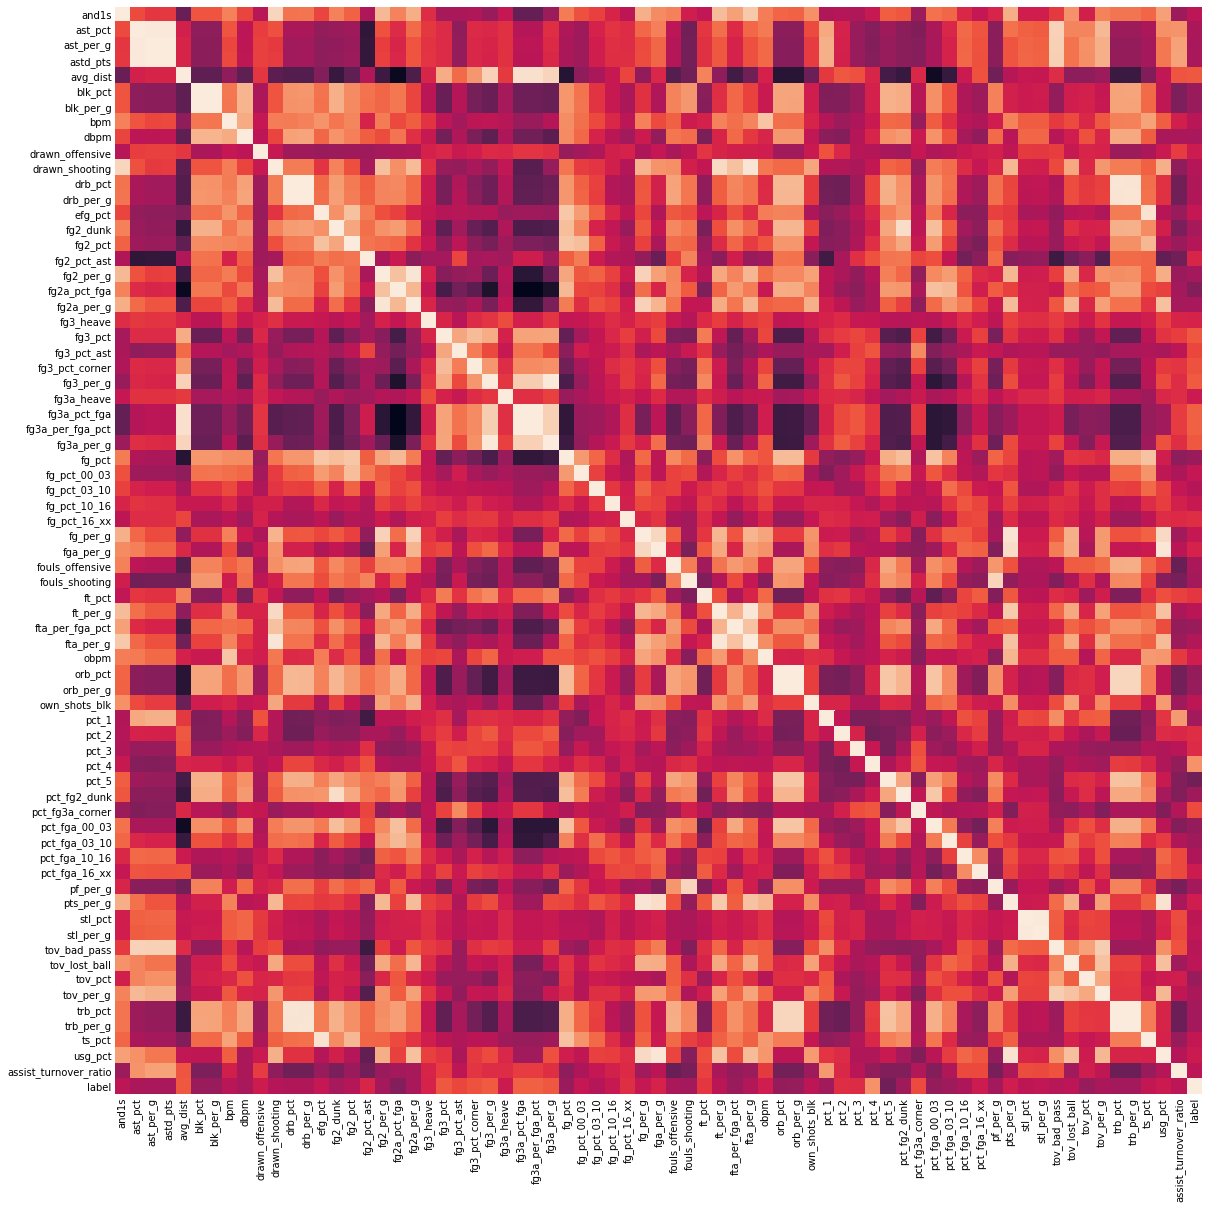

In [722]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(),square=True,cbar=False)
plt.savefig('../assets/raw_data_heatmap.png',dpi=500)

Thats a lot of correlation. Another useful approach is feature engineering. With the degree of multicollinearity present in this dataset, it may be possible to engineer features which can either capture the same variance in lower dimensions, or perhaps capture more variance not explained by the features independently. An example of this might be the assist-to-turnover ratio.

---
# Feature Engineering

---

### Positional Versatility
Some players only play point guard and will have the ball in their hands a vast majority of the time, like Steph Curry. Other players will only ever play at the Center position, and will likely be the tallest player on their team. There is an argument to be made that this stat does not belong in the analysis given the position of a player depends a lot on the team's composition and roster, but at the same time the ability to play the parts of the traditional roles is a useful information that may be captured by this stat.

In [599]:
X[['pct_1','pct_2','pct_3','pct_4','pct_5']].fillna('0').head()

,pct_1,pct_2,pct_3,pct_4,pct_5
name,,,,,
Klay Thompson,7.0,80.0,13.0,1.0,0.0
Draymond Green,0.0,0.0,59.0,39.0,2.0
Jordan Bell,0.0,0.0,0.0,14.0,86.0
Stephen Curry,98.0,2.0,0.0,0.0,0.0
Andre Iguodala,3.0,34.0,59.0,5.0,0.0


In [600]:
temp=[]
for player in X.index:
    row = X.loc[player][['pct_1','pct_2','pct_3','pct_4','pct_5']]
    rms = 1/np.sqrt(np.mean(row**2))
    temp.append(rms)
print('All Done!')

All Done!


In [602]:
X_sc['versatility']=((temp-np.mean(temp))/np.std(temp))
X_sc.drop(['pct_1','pct_2','pct_3','pct_4','pct_5'],axis=1,inplace=True)

### Contesting Shots
When a defender challenges an opponents shot, the shot either ends with a made shot, a blocked shot, a missed shot or a 'shooting foul' on the defender. I imagine the proportion of times a player blocks a shot relative to the amount of times they get called for a foul may be something of interest.

In [556]:
X[['fouls_shooting','blk_per_g']].head()

,fouls_shooting,blk_per_g
name,,
Klay Thompson,0.990950,0.635294
Draymond Green,1.621308,1.265176
Jordan Bell,2.467005,2.482759
Stephen Curry,1.003861,0.426036
Andre Iguodala,1.095057,1.241379


In [557]:
X[['fouls_shooting','blk_per_g']].corr()

,fouls_shooting,blk_per_g
fouls_shooting,1.000000,0.577517
blk_per_g,0.577517,1.000000


In [558]:
pd.DataFrame([X['blk_per_g']/(X['fouls_shooting']+X['blk_per_g']),X['blk_per_g']/X['fouls_shooting'],(X['blk_per_g']*X['fouls_shooting'])/(X['blk_per_g']+X['fouls_shooting'])]).T.describe()

,0,1,2
count,354.000000,354.000000,354.000000
mean,0.295315,0.478510,0.460152
std,0.134413,0.325103,0.300717
min,0.000000,0.000000,0.000000
25%,0.206982,0.261005,0.249339
50%,0.291225,0.410885,0.394172
75%,0.386569,0.630177,0.584750
max,0.655789,1.905195,1.952446


In [559]:
pd.DataFrame([X['blk_per_g']/(X['fouls_shooting']+X['blk_per_g']),X['blk_per_g']/X['fouls_shooting'],(X['blk_per_g']*X['fouls_shooting'])/(X['blk_per_g']+X['fouls_shooting'])]).T.corr()

,0,1,2
0,1.000000,0.96118,0.748583
1,0.961180,1.00000,0.725020
2,0.748583,0.72502,1.000000


Comparing blocks divided by shooting fouls with, blocks divided by the sum of the two as well as the inverse of the harmonic mean of the two is shown above. The three have a high pair-wise correlation, but I think I'll move ahead with blocks per shooting foul committed since it has a higher standard deviation, and has good interpretability.

In [561]:
temp = X['blk_per_g']/X['fouls_shooting']
X_sc.drop(['blk_per_g','fouls_shooting','blk_pct'],axis=1,inplace=True)
X_sc['block_rate'] = (temp-temp.mean())/temp.std()

### Drawing Fouls and Finishing Through Contact
Not many players are able to consistently finish a shot through a foul from their defender. This is refered to as an and-1 play since the player scores the points from their field goal attempt, and has the opportunity for one more at the freethrow line. The ability to do so at the rim indicates strength, while the ability to do so from further out is a knack that only certain players have, who are typically very good shooters. On the other hand, if the player is fouled and unable to finish the basket, they shoot two free throws. The ability to draw enough contact from defending players to force a ref to blow the whistle and send the player to the line for a few easy freethrows is a somewhat controversial aspect of the game. Perhaps the skill and/or strength required for an and-1 play can be captured by looking at the ratio of the two.

In [604]:
temp=X['and1s']/X['drawn_shooting']
X_sc.drop(['and1s','drawn_shooting'],axis=1,inplace=True)
X_sc['finish_through_contact'] = (temp-temp.mean()) / temp.std()

In [605]:
X_sc[['finish_through_contact']].sort_values('finish_through_contact',ascending=False).head()

,finish_through_contact
name,
Gary Clark,5.084960
Troy Daniels,3.089034
Tyler Dorsey,2.849523
Bryn Forbes,2.789645
Al Horford,2.568358


In [458]:
player = 'Al Horford'

and1s = X.loc[player]['and1s']
drawn_shooting = X.loc[player]['drawn_shooting']
ratio = X.loc[player]['and1s']/X.loc[player]['drawn_shooting']
print(f'And-1s Per 36: {and1s}\nDrawn Shooting Fouls Per 36: {drawn_shooting}\nRatio: {ratio}')

And-1s Per 36: 0.3831728332488596
Drawn Shooting Fouls Per 36: 0.8393309680689306
Ratio: 0.45652173913043476


### Drawing Charges & Offensive Fouls
In the NBA, the offending player is just as responsible for not bulldozing the defensive player as the defensive player is responsible for not being too physical in their defense of the offensive player. In many situations, smart defenders can use the positioning of their bodies to make headstrong offensive players turn the ball over by committing fouls. It can be a sign of physicality and smarts to both recognize the opportunity to draw an offensive foul and be willing to put your body on the line and take the charge. We may be able to approximate this by examining the rate at which a player can draw offensive fouls, given by the `drawn_offensive` category as compared to the number of non-shooting fouls.

In [490]:
temp = X['drawn_offensive']/(X['pf_per_g']-X['fouls_shooting']-X['fouls_offensive'])
X_sc['charge_draw_rate'] = (temp - np.mean(temp))/np.std(temp)
X_sc.drop(['drawn_offensive','pf_per_g','fouls_offensive'],axis=1,inplace=True)

### Root Mean Squared Shot Distribution
Some players are very good at dunking the basketball. Some players are 3pt aces. Some players can do a little bit of everything. We can take the root mean squared value of the percentage of a players shots that comes from different areas of the floor to try to tease apart the specialists from the generalists.

In [473]:
X[['pct_fga_00_03','pct_fga_03_10','pct_fga_10_16','pct_fga_16_xx','fg3a_pct_fga']].fillna('0').head()

,pct_fga_00_03,pct_fga_03_10,pct_fga_10_16,pct_fga_16_xx,fg3a_pct_fga
name,,,,,
Klay Thompson,0.138,0.073,0.148,0.215,0.427
Draymond Green,0.358,0.135,0.066,0.050,0.391
Jordan Bell,0.484,0.109,0.172,0.224,0.010
Stephen Curry,0.143,0.096,0.046,0.110,0.604
Andre Iguodala,0.344,0.050,0.056,0.073,0.477


In [481]:
temp=[]
for player in X.index:
    row = X.loc[player][['pct_fga_00_03','pct_fga_03_10','pct_fga_10_16','pct_fga_16_xx','fg3a_pct_fga']]
    rms = np.sqrt(np.mean(row**2))
    temp.append(rms)
print('All Done!')

All Done!


In [485]:
X_sc['shot_distribution']=(temp-np.mean(temp))/np.std(temp)
X_sc.drop(['pct_fga_00_03','pct_fga_03_10','pct_fga_10_16','pct_fga_16_xx','fg3a_pct_fga'],axis=1,inplace=True)

### Root Mean Squared Shot Selection
Continuing from the above, some players may be 3pt aces and some may not be. Some players will keep shooting threes even when they really shouldn't be. The root mean squared value of the product of a players shots from an area on the floor and the rate at which those shots go down could give a measure of how selective players are with their shots and how well they know their tendencies. It also should be noted that although the temptation is to think that a higher score, correlating to more selective and better shooting indicated better player performance, there may be a team-composition influence here in terms of how the offensive game plan generates shots for each player towards their strengths. Additionally, even okay players on bad teams will be forced to take bad shots to bail out the team's terrible defences.

In [518]:
X[['pct_fga_00_03','pct_fga_03_10','pct_fga_10_16','pct_fga_16_xx','fg3a_pct_fga']].fillna('0').head()

,pct_fga_00_03,pct_fga_03_10,pct_fga_10_16,pct_fga_16_xx,fg3a_pct_fga
name,,,,,
Klay Thompson,0.138,0.073,0.148,0.215,0.427
Draymond Green,0.358,0.135,0.066,0.050,0.391
Jordan Bell,0.484,0.109,0.172,0.224,0.010
Stephen Curry,0.143,0.096,0.046,0.110,0.604
Andre Iguodala,0.344,0.050,0.056,0.073,0.477


In [519]:
X[['fg_pct_00_03','fg_pct_03_10', 'fg_pct_10_16', 'fg_pct_16_xx','fg3_pct']].fillna('0').head()

,fg_pct_00_03,fg_pct_03_10,fg_pct_10_16,fg_pct_16_xx,fg3_pct
name,,,,,
Klay Thompson,0.715,0.422,0.478,0.445,0.402
Draymond Green,0.702,0.316,0.393,0.286,0.285
Jordan Bell,0.688,0.381,0.455,0.279,0
Stephen Curry,0.649,0.488,0.419,0.439,0.437
Andre Iguodala,0.856,0.200,0.294,0.273,0.333


In [542]:
X.fillna(0,inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [549]:
temp=[]
for player in X.index:
    a=X.loc[player]['pct_fga_00_03']*X.loc[player]['fg_pct_00_03']
    b=X.loc[player]['pct_fga_03_10']*X.loc[player]['fg_pct_03_10']
    c=X.loc[player]['pct_fga_10_16']*X.loc[player]['fg_pct_10_16']
    d=X.loc[player]['pct_fga_16_xx']*X.loc[player]['fg_pct_16_xx']
    e=X.loc[player]['fg3a_pct_fga']*X.loc[player]['fg3_pct']
    rms = 1/np.sqrt(np.mean(np.array([a,b,c,d,e])**2))
    temp.append(rms)
print('All Done!')

All Done!


In [552]:
X_sc['shot_selection'] = (temp-np.mean(temp))/np.std(temp)
X_sc.drop(['fg_pct_00_03','fg_pct_03_10', 'fg_pct_10_16', 'fg_pct_16_xx','fg3_pct'],axis=1,inplace=True)

### Assist-to-Turnover Ratio
A traditional metric for measuring the success of playmakers is the number of times their passes directly result in a made basket, as compared to the number of times they turn the ball over. Any player will necessarily make more errant passes the more time they're on the court but great passers will minimize those and maximize their teams productivity by placing passes in the right place at the right time. We'll calculate that here.

In [497]:
X[['ast_per_g','ast_pct']].corr()

,ast_per_g,ast_pct
ast_per_g,1.000000,0.984488
ast_pct,0.984488,1.000000


These two are essentially the same numbers. assist percentage is pace adjusted to be per 100 possessions but to keep it consistent we'll use per-36 stats.

In [584]:
X[['tov_bad_pass','tov_pct']].corr()

,tov_bad_pass,tov_pct
tov_bad_pass,1.000000,0.617425
tov_pct,0.617425,1.000000


There are plenty of ways to turn the ball over that don't involve errant passes. None of them are less embarassing.

In [585]:
temp = X['ast_per_g']/X['tov_bad_pass']
X_sc['assist_turnover_ratio'] = (temp-np.mean(temp))/np.std(temp)
X_sc.drop(['ast_per_g','tov_bad_pass','tov_per_g','ast_pct','tov_pct'],axis=1,inplace=True)

###  Isolation Effectiveness
Some players have a strong tendency to play 1-on-1 basketball with their defenders. These are referred to as isolation situations. These are characterized by the player often making multiple moves before attempting to score (rendering the person who passed them the ball ineligible for assists) and often times with turnovers by mishandling the ball against good defenders.

In [570]:
isos = ((1-X['fg2_pct_ast'])*X['fg2a_pct_fga'] + (1-X['fg3_pct_ast'])*X['fg3a_pct_fga'])*X['fga_per_g']

In [573]:
temp = isos/(isos+X['tov_lost_ball'])
X_sc['iso_effectiveness'] = (temp-np.mean(temp))/np.std(temp)
X_sc.drop(['fg2_pct_ast','fg2a_pct_fga','fg3_pct_ast','fga_per_g','tov_lost_ball'],axis=1,inplace=True)

### Efficient-Shot Selection
The NBA 3pt line is a curve 22 feet away from the rim for the most part, but in the corners of the court, the arc becomes a straight line perpendicular to the baseline. This means that corner 3pt attempts are at least a full foot closer to the basket, are easier to hit but are worth the same amount and are therefore considered high efficiency shots (This is typically measured by points-per-possession on those types of shots). Additionally, layups within 0-3 feet of the basket reward as many points as jump shouts out to 21 feet away, and by virtue of their proximity to the basket, are typically considered good shots to take (again this is demonstrated in the points-per-possession stats on layups). Finally, dunks are often considered better shots than layups because you're much less likely to miss on those. Players who take these types of shots disproportionately may be good role players, taking efficient shots.

In [626]:
temp = (X['pct_fg3a_corner']*X['fg3a_per_g'] + X['pct_fg2_dunk'])

In [628]:
X_sc['efficient_shot_taker']=(temp-np.mean(temp))/np.std(temp)
X_sc.drop(['pct_fg3a_corner','fg3a_per_g','pct_fg2_dunk'],axis=1,inplace=True)

### Offensive-Defensive Rebound Ratio
There are many players, typically large, athletic young guys with crazy motors who earn their paychecks by trying to snag up as many offensive rebounds (off own/team-mate misses) as possible. For these players, the Offensive-Defensive rebound ratio is higher.

In [588]:
temp = X['orb_per_g']/X['drb_per_g']
X_sc['off_def_rebound'] = (temp-np.mean(temp))/np.std(temp)
X_sc.drop(['orb_per_g','drb_per_g','orb_pct','drb_pct','trb_pct'],axis=1,inplace=True)

### Offensive-Defensive Boxscore Plus Minus Ratio
A boxscore plus-minus is a very simple measure; when this player is on the court, does the team outscore their opponents? This is broken down into estimates of the players contribution to the teams offense and defense. Although there may be a strong team component here (a single great defensive player won't be able to stop a whole team from scoring if surrounded by terrible defensive teammates), whether or not the defensive plus-minus is higher than the offensive could be a good indicator of a player's tendencies.

In [702]:
temp = (X['obpm']-X['dbpm'])
X_sc['net_offensive_bpm'] = (temp-np.mean(temp))/np.std(temp)
X_sc.drop(['obpm','dbpm'],axis=1,inplace=True)

### Dropping Additional Columns
The columns dropped below are ones I imagine are explained in no small part by the other features presented here.

In [650]:
X_sc.drop(['fta_per_g','fta_per_g','tov_bad_pass','stl_pct','bpm','fg_per_g'],axis=1,inplace=True)
X_sc.drop(['fg3_heave','fg3a_heave','efg_pct','fg3a_per_fga_pct','fg2_per_g','fg2a_per_g','drb_pct','orb_pct','trb_pct'],axis=1,inplace=True)

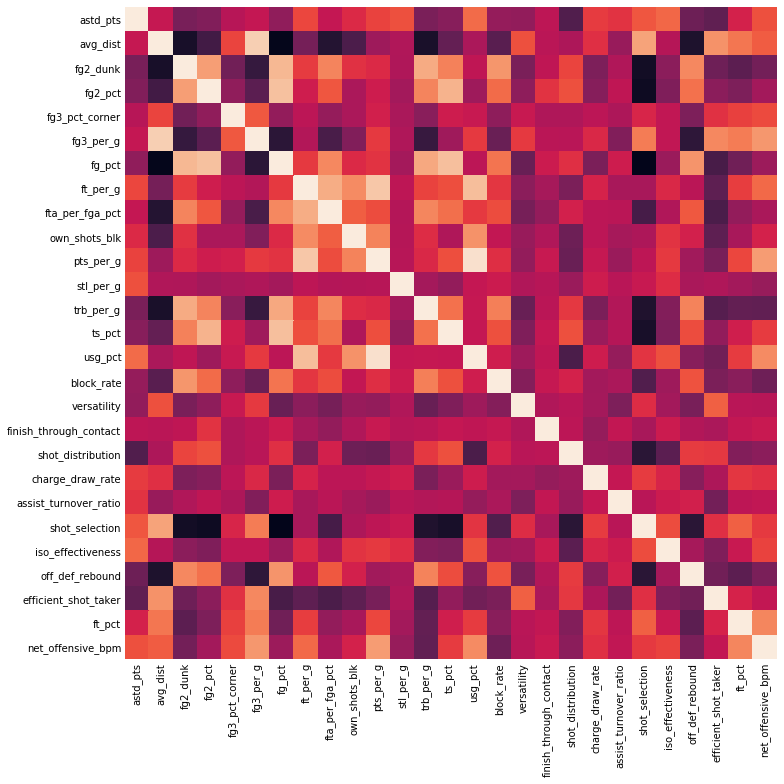

In [721]:
plt.figure(figsize=(12,12))
sns.heatmap(X_sc.corr(),square=True,cbar=False)
plt.savefig('../assets/feat_eng_heatmap.png',dpi=500)

At the very least, this correlation plot is a lot smaller than the one we had prior to feature engineering. The average pairwise correlation also looks smaller, and that the engineered features are not highly collinear is encouraging.

In [705]:
print(f'Mean Pairwise Correlation Before Feature Engineering: {round(np.mean(np.mean(X.corr())),4)}, Standard Deviation of {round(np.std(np.std(X.corr())),4)}')
print(f'Mean Pairwise Correlation After Feature Engineering: {round(np.mean(np.mean(X_sc.corr())),4)}, Standard Deviation of {round(np.std(np.std(X_sc.corr())),4)}')

Mean Pairwise Correlation Before Feature Engineering: 0.0897, Standard Deviation of 0.0875
Mean Pairwise Correlation After Feature Engineering: 0.0682, Standard Deviation of 0.0831


Indeed, this is borne out by the average pairwise correlations of the two dataframes and their standard deviations.

In [706]:
X_sc.to_csv('../data/players_feat_eng_scaled.csv')

In [717]:
X.to_csv('../data/players.csv')